In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
DATA_DIR = '../pickles'
CAPTORS_LIST = ('NO2_61FD', 'NO2_61F0', 'NO2_61EF')

In [3]:
df = pd.read_pickle(os.path.join(DATA_DIR, 'station1_normalized.pkl'))
df.head(10)

,date,ref,NO2_61FD,NO2_61F0,NO2_61EF,rh,t_grad,pressure,temp,pluvio
0,2017-09-28 10:15:00,38.5,-0.324687,-0.487027,0.433465,0.167023,-1.039505,0.375594,0.898638,0.0
1,2017-09-28 10:30:00,32.3,-0.343192,-0.325877,-0.412283,0.083982,-1.094050,0.375594,0.946776,0.0
2,2017-09-28 10:45:00,38.5,-0.010107,-0.161505,-0.198236,0.065528,-0.984961,0.375594,0.970844,0.0
3,2017-09-28 11:00:00,29.7,-0.386370,-0.554710,-0.339194,-0.063647,-0.984961,0.356064,1.091187,0.0
4,2017-09-28 11:15:00,19.4,-0.386370,-0.422567,-0.412283,-0.146688,-1.203138,0.375594,1.163393,0.0
5,2017-09-28 11:30:00,10.8,-0.386370,-0.619170,-0.412283,-0.238957,-1.039505,0.375594,1.259668,0.0
6,2017-09-28 11:45:00,12.4,-0.386370,-0.586940,-0.412283,-0.358905,-1.203138,0.375594,1.283736,0.0
7,2017-09-28 12:00:00,12.3,-0.386370,-0.619170,-0.412283,-0.405039,-1.148594,0.375594,1.307805,0.0
8,2017-09-28 12:15:00,9.7,-0.386370,-0.619170,-0.412283,-0.423493,-1.312227,0.356064,1.355942,0.0
9,2017-09-28 12:30:00,13.8,-0.386370,-0.619170,-0.412283,-0.552668,-1.475859,0.356064,1.548491,0.0


In [4]:
def from_dataframe_to_xy(df, captor_idx):
    return (np.array(df[[CAPTORS_LIST[captor_idx], 'temp', 'rh', 't_grad', 'pressure', 'pluvio']]),
            np.array(df['ref']))

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

In [5]:
def gru_plus_dense(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='relu'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opti = Adam(lr=0.0003)
    model.compile(loss=loss, optimizer=opti)
    
    return model

early_stopping = EarlyStopping(patience=10)
reduce_lr_on_plateau = ReduceLROnPlateau()

- CAPTOR: NO2_61FD
	 Score = 391.8596729


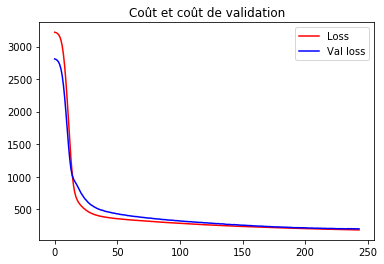

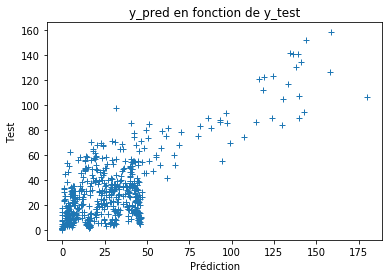

- CAPTOR: NO2_61F0
	 Score = 139.965065053


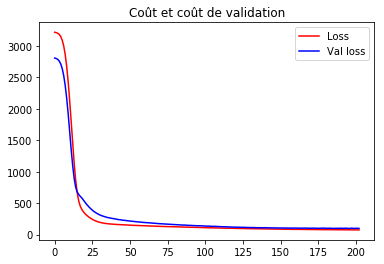

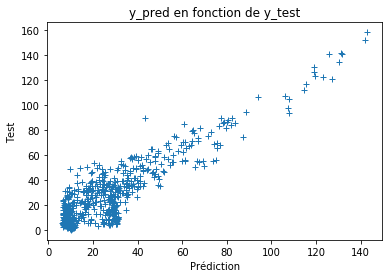

- CAPTOR: NO2_61EF
	 Score = 354.924350612


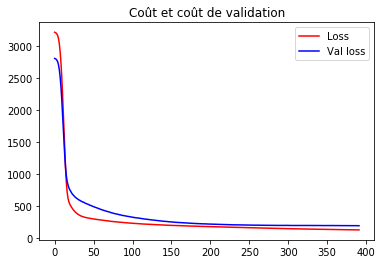

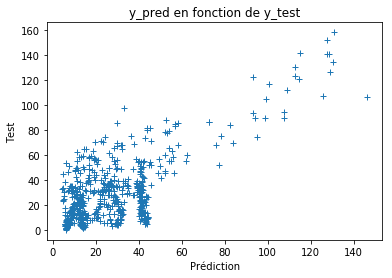

In [6]:
df_train, df_test = split_dataframe(df, 0.5)
df_valid, df_test = split_dataframe(df_test, 0.5)

### BIG LOOP TO TRAIN ON EACH MICROCAPTOR INDEPENDANTLY

for i in range(len(CAPTORS_LIST)):
    print("- CAPTOR: {}".format(CAPTORS_LIST[i]))
    X_train, y_train = from_dataframe_to_xy(df_train, i)
    X_valid, y_valid = from_dataframe_to_xy(df_valid, i)
    X_test, y_test = from_dataframe_to_xy(df_test, i)
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = gru_plus_dense(32, X_train.shape[1:])
    
    history = model.fit(X_train, y_train, \
                        batch_size=32, \
                        epochs=10000, \
                        validation_data=(X_valid, y_valid), \
                        callbacks=[early_stopping, reduce_lr_on_plateau],
                        verbose=0)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print("\t Score = {}".format(str(score)))
    
    y_pred = model.predict(X_test)
    plt.title('Coût et coût de validation')
    line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
    line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
    first_legend = plt.legend(handles=[line1, line2], loc=1)

    plt.show()

    plt.title('y_pred en fonction de y_test')

    plt.plot(y_pred[:], y_test[:], '+')
    plt.ylabel('Test')
    plt.xlabel('Prédiction')
    plt.show()

In [7]:
df_train_valid = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
df_test = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
for i in range(len(df)):
    row = df.iloc[i]
    df_train_valid.loc[2*i] = [row.date, row.ref, row.NO2_61FD, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_train_valid.loc[2*i + 1] = [row.date, row.ref, row.NO2_61F0, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_test.loc[i] = [row.date, row.ref, row.NO2_61EF, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]

In [8]:
df_train_valid.head()

,date,ref,no2,rh,t_grad,pressure,temp,pluvio
0,2017-09-28 10:15:00,38.5,-0.324687,0.167023,-1.039505,0.375594,0.898638,0.0
1,2017-09-28 10:15:00,38.5,-0.487027,0.167023,-1.039505,0.375594,0.898638,0.0
2,2017-09-28 10:30:00,32.3,-0.343192,0.083982,-1.094050,0.375594,0.946776,0.0
3,2017-09-28 10:30:00,32.3,-0.325877,0.083982,-1.094050,0.375594,0.946776,0.0
4,2017-09-28 10:45:00,38.5,-0.010107,0.065528,-0.984961,0.375594,0.970844,0.0


In [9]:
def from_dataframe_to_xy_1_sensor(df):
    return (np.array(df[['no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio']]),
            np.array(df['ref']))

df_train, df_valid = split_dataframe(df_train_valid, 0.5)
X_train, y_train = from_dataframe_to_xy_1_sensor(df_train)
X_valid, y_valid = from_dataframe_to_xy_1_sensor(df_valid)
X_test, y_test = from_dataframe_to_xy_1_sensor(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Train on 2413 samples, validate on 2413 samples
Epoch 1/10000
2413/2413 [==============================] - 1s 509us/step - loss: 3217.0357 - val_loss: 2194.9047
Epoch 2/10000
2413/2413 [==============================] - 0s 79us/step - loss: 3200.4304 - val_loss: 2171.8013
Epoch 3/10000
2413/2413 [==============================] - 0s 81us/step - loss: 3145.5583 - val_loss: 2107.0894
Epoch 4/10000
2413/2413 [==============================] - 0s 83us/step - loss: 2997.0105 - val_loss: 1965.1724
Epoch 5/10000
2413/2413 [==============================] - 0s 79us/step - loss: 2696.8829 - val_loss: 1728.1997
Epoch 6/10000
2413/2413 [==============================] - 0s 85us/step - loss: 2221.9579 - val_loss: 1424.9602
Epoch 7/10000
2413/2413 [==============================] - 0s 79us/step - loss: 1649.0282 - val_loss: 1135.3412
Epoch 8/10000
2413/2413 [==============================] - 0s 80us/step - loss: 1133.3918 - val_loss: 940.5522
Epoch 9/10000
2413/2413 [==============================]

2413/2413 [==============================] - 0s 77us/step - loss: 181.9884 - val_loss: 238.5758
Epoch 75/10000
2413/2413 [==============================] - 0s 85us/step - loss: 180.9224 - val_loss: 238.7909
Epoch 76/10000
2413/2413 [==============================] - 0s 77us/step - loss: 179.9850 - val_loss: 235.1796
Epoch 77/10000
2413/2413 [==============================] - 0s 77us/step - loss: 178.8721 - val_loss: 236.7319
Epoch 78/10000
2413/2413 [==============================] - 0s 77us/step - loss: 177.8990 - val_loss: 236.8706
Epoch 79/10000
2413/2413 [==============================] - 0s 78us/step - loss: 176.9820 - val_loss: 234.7656
Epoch 80/10000
2413/2413 [==============================] - 0s 77us/step - loss: 176.1019 - val_loss: 233.4344
Epoch 81/10000
2413/2413 [==============================] - 0s 79us/step - loss: 175.1925 - val_loss: 233.4475
Epoch 82/10000
2413/2413 [==============================] - 0s 78us/step - loss: 174.1258 - val_loss: 234.1519
Epoch 83/10000
2

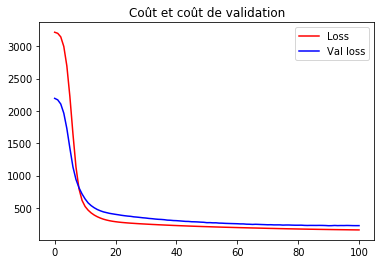

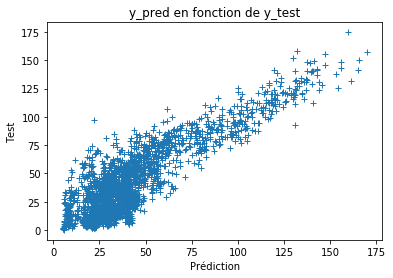

In [10]:
model = gru_plus_dense(32, X_train.shape[1:])
early_stopping = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=10000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                    verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print("\t Score = {}".format(str(score)))

y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

Train on 2413 samples, validate on 2413 samples
Epoch 1/10000
2413/2413 [==============================] - 1s 526us/step - loss: 3209.5237 - val_loss: 2186.5550
Epoch 2/10000
2413/2413 [==============================] - 0s 79us/step - loss: 3183.0888 - val_loss: 2153.3399
Epoch 3/10000
2413/2413 [==============================] - 0s 80us/step - loss: 3108.3145 - val_loss: 2071.9238
Epoch 4/10000
2413/2413 [==============================] - 0s 79us/step - loss: 2928.9215 - val_loss: 1910.1984
Epoch 5/10000
2413/2413 [==============================] - 0s 84us/step - loss: 2577.2598 - val_loss: 1647.0458
Epoch 6/10000
2413/2413 [==============================] - 0s 80us/step - loss: 2039.7490 - val_loss: 1321.8338
Epoch 7/10000
2413/2413 [==============================] - 0s 80us/step - loss: 1421.3988 - val_loss: 1027.3013
Epoch 8/10000
2413/2413 [==============================] - 0s 84us/step - loss: 915.0696 - val_loss: 834.8996
Epoch 9/10000
2413/2413 [==============================] 

2413/2413 [==============================] - 0s 84us/step - loss: 139.5769 - val_loss: 234.4155
Epoch 75/10000
2413/2413 [==============================] - 0s 79us/step - loss: 138.8064 - val_loss: 232.4404
Epoch 76/10000
2413/2413 [==============================] - 0s 78us/step - loss: 137.7490 - val_loss: 229.2307
Epoch 77/10000
2413/2413 [==============================] - 0s 77us/step - loss: 136.9411 - val_loss: 227.5650
Epoch 78/10000
2413/2413 [==============================] - 0s 78us/step - loss: 136.2451 - val_loss: 226.8164
Epoch 79/10000
2413/2413 [==============================] - 0s 80us/step - loss: 135.4834 - val_loss: 224.5978
Epoch 80/10000
2413/2413 [==============================] - 0s 79us/step - loss: 134.8294 - val_loss: 224.1352
Epoch 81/10000
2413/2413 [==============================] - 0s 77us/step - loss: 133.9218 - val_loss: 222.0227
Epoch 82/10000
2413/2413 [==============================] - 0s 80us/step - loss: 133.4431 - val_loss: 220.7282
Epoch 83/10000
2

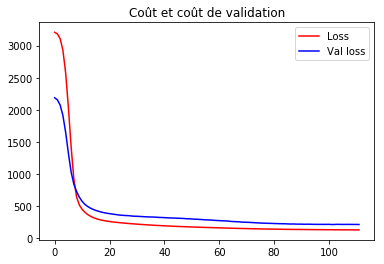

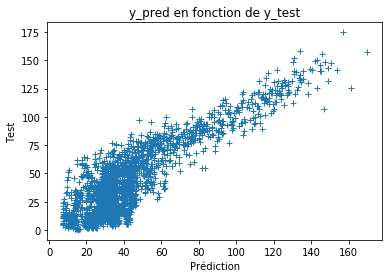

In [11]:
df_train_valid = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
df_test = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
for i in range(len(df)):
    row = df.iloc[i]
    df_train_valid.loc[2*i] = [row.date, row.ref, row.NO2_61EF, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_train_valid.loc[2*i + 1] = [row.date, row.ref, row.NO2_61F0, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_test.loc[i] = [row.date, row.ref, row.NO2_61FD, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    
df_train, df_valid = split_dataframe(df_train_valid, 0.5)
X_train, y_train = from_dataframe_to_xy_1_sensor(df_train)
X_valid, y_valid = from_dataframe_to_xy_1_sensor(df_valid)
X_test, y_test = from_dataframe_to_xy_1_sensor(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = gru_plus_dense(32, X_train.shape[1:])
early_stopping = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=10000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                    verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print("\t Score = {}".format(str(score)))

y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

Train on 2413 samples, validate on 2413 samples
Epoch 1/10000
2413/2413 [==============================] - 1s 499us/step - loss: 3206.2904 - val_loss: 2185.1400
Epoch 2/10000
2413/2413 [==============================] - 0s 81us/step - loss: 3176.6445 - val_loss: 2151.0336
Epoch 3/10000
2413/2413 [==============================] - 0s 82us/step - loss: 3088.9231 - val_loss: 2057.6029
Epoch 4/10000
2413/2413 [==============================] - 0s 82us/step - loss: 2869.2748 - val_loss: 1860.2033
Epoch 5/10000
2413/2413 [==============================] - 0s 82us/step - loss: 2451.1473 - val_loss: 1548.0377
Epoch 6/10000
2413/2413 [==============================] - 0s 81us/step - loss: 1861.4528 - val_loss: 1192.1697
Epoch 7/10000
2413/2413 [==============================] - 0s 81us/step - loss: 1262.1110 - val_loss: 925.1186
Epoch 8/10000
2413/2413 [==============================] - 0s 80us/step - loss: 855.9167 - val_loss: 794.3302
Epoch 9/10000
2413/2413 [==============================] -

2413/2413 [==============================] - 0s 80us/step - loss: 221.6122 - val_loss: 293.3360
Epoch 75/10000
2413/2413 [==============================] - 0s 81us/step - loss: 220.2568 - val_loss: 290.1487
Epoch 76/10000
2413/2413 [==============================] - 0s 83us/step - loss: 219.4380 - val_loss: 289.7463
Epoch 77/10000
2413/2413 [==============================] - 0s 79us/step - loss: 218.3923 - val_loss: 288.0630
Epoch 78/10000
2413/2413 [==============================] - 0s 79us/step - loss: 217.2519 - val_loss: 284.6187
Epoch 79/10000
2413/2413 [==============================] - 0s 80us/step - loss: 216.2121 - val_loss: 285.3036
Epoch 80/10000
2413/2413 [==============================] - 0s 82us/step - loss: 215.2690 - val_loss: 281.8350
Epoch 81/10000
2413/2413 [==============================] - 0s 80us/step - loss: 214.1689 - val_loss: 281.7749
Epoch 82/10000
2413/2413 [==============================] - 0s 80us/step - loss: 213.2764 - val_loss: 279.9653
Epoch 83/10000
2

2413/2413 [==============================] - 0s 79us/step - loss: 168.7478 - val_loss: 251.1564
Epoch 148/10000
2413/2413 [==============================] - 0s 82us/step - loss: 168.3748 - val_loss: 251.7143
Epoch 149/10000
2413/2413 [==============================] - 0s 87us/step - loss: 167.9460 - val_loss: 252.2179
Epoch 150/10000
2413/2413 [==============================] - 0s 89us/step - loss: 167.3936 - val_loss: 251.6527
Epoch 151/10000
2413/2413 [==============================] - 0s 88us/step - loss: 166.8388 - val_loss: 251.8767
Epoch 152/10000
2413/2413 [==============================] - 0s 82us/step - loss: 166.6138 - val_loss: 250.2891
Epoch 153/10000
2413/2413 [==============================] - 0s 85us/step - loss: 166.3050 - val_loss: 250.6759
	 Score = 170.747056097


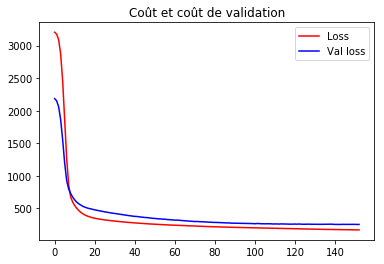

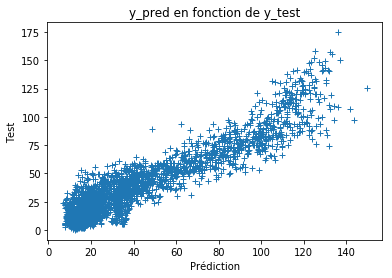

In [12]:
df_train_valid = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
df_test = pd.DataFrame(columns=['date', 'ref', 'no2', 'rh', 't_grad', 'pressure', 'temp', 'pluvio'])
for i in range(len(df)):
    row = df.iloc[i]
    df_train_valid.loc[2*i] = [row.date, row.ref, row.NO2_61EF, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_train_valid.loc[2*i + 1] = [row.date, row.ref, row.NO2_61FD, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    df_test.loc[i] = [row.date, row.ref, row.NO2_61F0, row.rh, row.t_grad, row.pressure, row.temp, row.pluvio]
    
df_train, df_valid = split_dataframe(df_train_valid, 0.5)
X_train, y_train = from_dataframe_to_xy_1_sensor(df_train)
X_valid, y_valid = from_dataframe_to_xy_1_sensor(df_valid)
X_test, y_test = from_dataframe_to_xy_1_sensor(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = gru_plus_dense(32, X_train.shape[1:])
early_stopping = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, \
                    batch_size=32, \
                    epochs=10000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping, reduce_lr_on_plateau],
                    verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print("\t Score = {}".format(str(score)))

y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()